## Convolutional Neural Network 활용
-----
- CNN을 구성하는 주요 연산을 이해하고, 신경망을 설계한다.
- AlexNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- 이미지 증강을 수행하여 모델의 성능을 높이는 방법을 이해한다.
- Confusion Matrix를 생성하여 분류 정확도를 확인한다.
- **reference**
    - https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
    - https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
    - https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

# 1번
- 필요한 모듈을 모두 이곳에 나열하세요
- 2점

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, RandomCrop, RandomHorizontalFlip, Normalize
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 2번
- CIFAR 데이터(train, test)를 불러오세요
- 2점

In [2]:
train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform= ToTensor()
    )

test = datasets.CIFAR10(
    root='./data',
    train=False,
    transform= ToTensor()
    )

100%|██████████| 170498071/170498071 [00:04<00:00, 42509441.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# 3번
- 불러온 이미지의 증강을 합니다.
- RandomCrop, RandomHorizontalFlip, Normalize
- Compose 함수를 이용합니다.
- train에는 RandomCrop(28, padding=4), RandomHorizontalFlip, Normalize를 적용한다.
- test에는 Normalize를 적용한다.
- 2점

In [3]:
train_transform = Compose([
    RandomCrop(28, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # CIFAR-10 데이터셋의 채널별 평균과 표준편차임
])

train.transform = train_transform

In [4]:
test_transform = Compose([
    RandomCrop(28, padding=4),
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # CIFAR-10 데이터셋의 채널별 평균과 표준편차임
])

test.transform = test_transform

# 4번
- Device 설정은 GPU로 합니다
- 2점

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 5번
- train, test의 shape를 확인합니다.
- 2점

In [6]:
print(train.data.shape)
print(test.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# 6번
- train, test DataLoader를 만듭니다.
- 배치사이즈: 128
- 2점

In [7]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# 7번
- train, test의 첫번째 인덱스 데이터를 이미지로 확인합니다.
- 2점

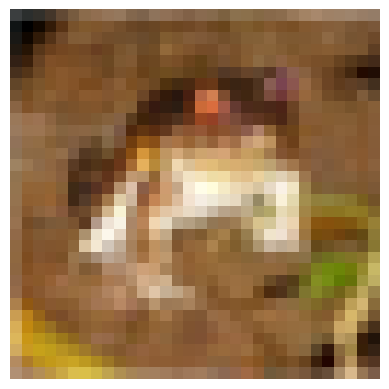

In [8]:
plt.imshow(train.data[0])
plt.axis('off')
plt.show()

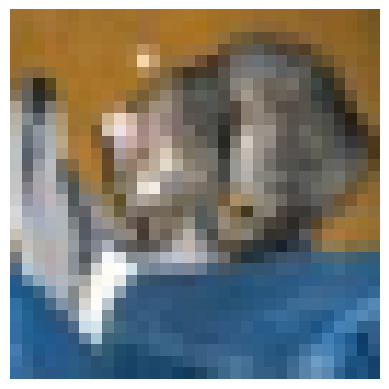

In [9]:
plt.imshow(test.data[0])
plt.axis('off')
plt.show()

# 8번
- CIFAR의 클래스를 labels_map 이름의 딕셔너리로 생성합니다.
- 2점

In [10]:
labels_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# 9번
- 5행 5열로 train 데이터를 이미지로 출력합니다.
- labels_map를 이용하여 이미지의 label도 함께 출력합니다.
- 2점

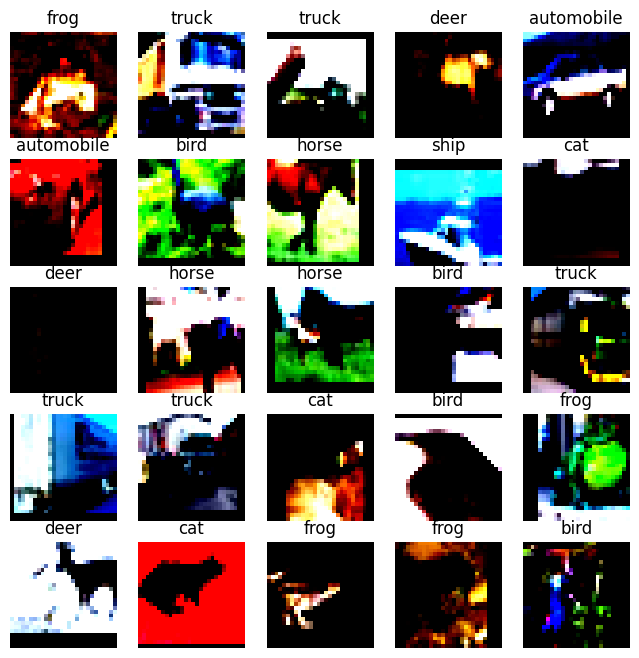

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
axes = axes.flatten()

for i in range(25):
    img, label = train[i]
    ax = axes[i]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(labels_map[label])
    ax.axis('off')

plt.show()

# 10번
- AlexNet(https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg)
- 위 모델을 참조하여 class를 만듭니다.
- 2점

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 2 * 2, 4096),  # 크기 조정
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)  # 텐서를 평탄화 (Flatten)
        x = self.classifier(x)
        return x

# 11번
- 인공신경망 객체를 GPU에 저장합니다.
- 3점

In [13]:
model = AlexNet(num_classes=10).to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

# 12번
- Loss 함수를 정의합니다.
- 학습률을 0.001로 설정합니다.
- 옵티마이저는 Adam을 사용합니다.
- 3점

In [14]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 13번
- 학습 함수를 train_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수, 옵티마이저)
- 데이터로더의 인덱스가 배치사이즈마다 loss를 출력합니다.
- 3점

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 130 == 0:
            print(f"Batch {i}: Loss = {loss.item()}")

# 14번
- 테스트 함수를 test_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수)
- 데이터로더의 크기만큼 반복하며 loss를 출력하고 전체 accuracy와 평균 loss를 구합니다.
- 3점

In [16]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            total_loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print('loss: ', loss_fn(pred, y).item())

    avg_loss= total_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)

    return avg_loss, accuracy

# 15번
- 100번의 epochs를 돌며 학습을 반복합니다.
- 3점

In [17]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}번째")
    train_loop(train_loader, model, loss_fn, optimizer)
print('학습 완료')

Epoch 1번째
Batch 0: Loss = 2.302234172821045
Batch 130: Loss = 1.9971396923065186
Batch 260: Loss = 1.9655115604400635
Batch 390: Loss = 1.6082117557525635
Epoch 2번째
Batch 0: Loss = 1.7681303024291992
Batch 130: Loss = 1.5113906860351562
Batch 260: Loss = 1.6206549406051636
Batch 390: Loss = 1.5404374599456787
Epoch 3번째
Batch 0: Loss = 1.571998953819275
Batch 130: Loss = 1.5451593399047852
Batch 260: Loss = 1.4619837999343872
Batch 390: Loss = 1.4559428691864014
Epoch 4번째
Batch 0: Loss = 1.592340350151062
Batch 130: Loss = 1.3829429149627686
Batch 260: Loss = 1.4215576648712158
Batch 390: Loss = 1.5197068452835083
Epoch 5번째
Batch 0: Loss = 1.591943383216858
Batch 130: Loss = 1.4126651287078857
Batch 260: Loss = 1.5310816764831543
Batch 390: Loss = 1.3418253660202026
Epoch 6번째
Batch 0: Loss = 1.4017338752746582
Batch 130: Loss = 1.2717376947402954
Batch 260: Loss = 1.4271721839904785
Batch 390: Loss = 1.436590313911438
Epoch 7번째
Batch 0: Loss = 1.3301153182983398
Batch 130: Loss = 1.3392

# 16번
- 사이킷런의 confusion_matrix를 활용해 학습된 결과에 대해 분석합니다.
- 분석한 결과를 간단히 서술합니다.
- 3점

In [19]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        all_preds.append(preds.argmax(dim=1).cpu().numpy())
        all_labels.append(y.cpu().numpy())

predictions = np.concatenate(all_preds)
true_labels = np.concatenate(all_labels)

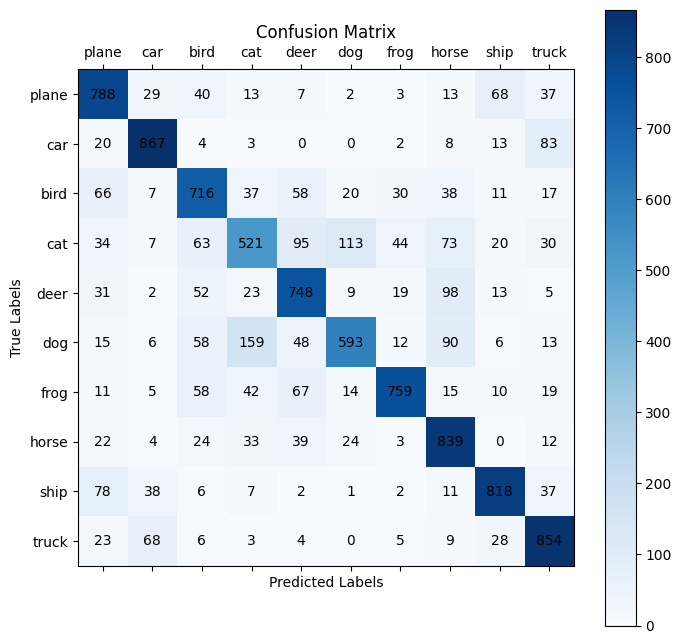

In [20]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(true_labels, predictions)
# 클래스 이름 리스트 (예: 10개의 클래스를 가진 CIFAR-10 데이터셋)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 플롯 생성
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# 혼동 행렬을 색상 맵으로 시각화
cax = ax.matshow(conf_mat, cmap='Blues')

# 색상 막대 추가
fig.colorbar(cax)

# x축 및 y축 레이블 추가
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# 축의 레이블 설정
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# 각 셀에 혼동 행렬 값을 추가
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='black')

# 제목 추가 및 저장
plt.title('Confusion Matrix')
plt.savefig("Conf_Mat.jpg")
plt.show()

In [ ]:
# 음 잘된듯. 확실히 개와 고양이 정확도가 좋지 않네요.

# 17번
- 학습된 파라미터를 저장합니다.
- 파일명은 model_weights.pth로 합니다.
- 3점

In [21]:
torch.save(model.state_dict(), 'model_weights.pth')

# 18번
- 새로운 인공신경망을 GPU에 만들고 위 학습된 파일(model_weights.pth)을 불러옵니다.
- 3점

In [22]:
new_model = AlexNet(num_classes=10).to(device)
new_model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

# 19번
- 위 모델에 test 데이터로더를 입력하고 결과를 확인합니다.
- 3점

In [23]:
test_loss, test_accuracy = test_loop(test_loader, new_model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

loss:  0.8974632620811462
loss:  0.7238099575042725
loss:  0.6648685932159424
loss:  0.7075371146202087
loss:  0.624096155166626
loss:  0.8081029653549194
loss:  0.9629845023155212
loss:  0.6168627142906189
loss:  0.749454140663147
loss:  0.7159585356712341
loss:  0.8116405010223389
loss:  0.7295344471931458
loss:  0.7550493478775024
loss:  0.825398862361908
loss:  0.8166800737380981
loss:  0.9131982326507568
loss:  0.8337112069129944
loss:  0.7708846926689148
loss:  0.6481441259384155
loss:  0.8028193712234497
loss:  0.6108438372612
loss:  0.8418222665786743
loss:  0.7190978527069092
loss:  0.8421036601066589
loss:  0.7708796262741089
loss:  0.7529258131980896
loss:  0.7878569960594177
loss:  0.7184818387031555
loss:  0.8004122972488403
loss:  0.8358069658279419
loss:  0.657093346118927
loss:  0.6753473877906799
loss:  0.8192888498306274
loss:  0.7134712338447571
loss:  0.6712836027145386
loss:  0.7371867299079895
loss:  0.6821937561035156
loss:  0.6610649228096008
loss:  0.7209385037

# 20번
- 5행 5열로 test 데이터를 이미지로 출력합니다.
- 학습된 모델이 분류기가 잘 작동하는지 label과 예측된 결과를 동시에 출력합니다.
- 3점

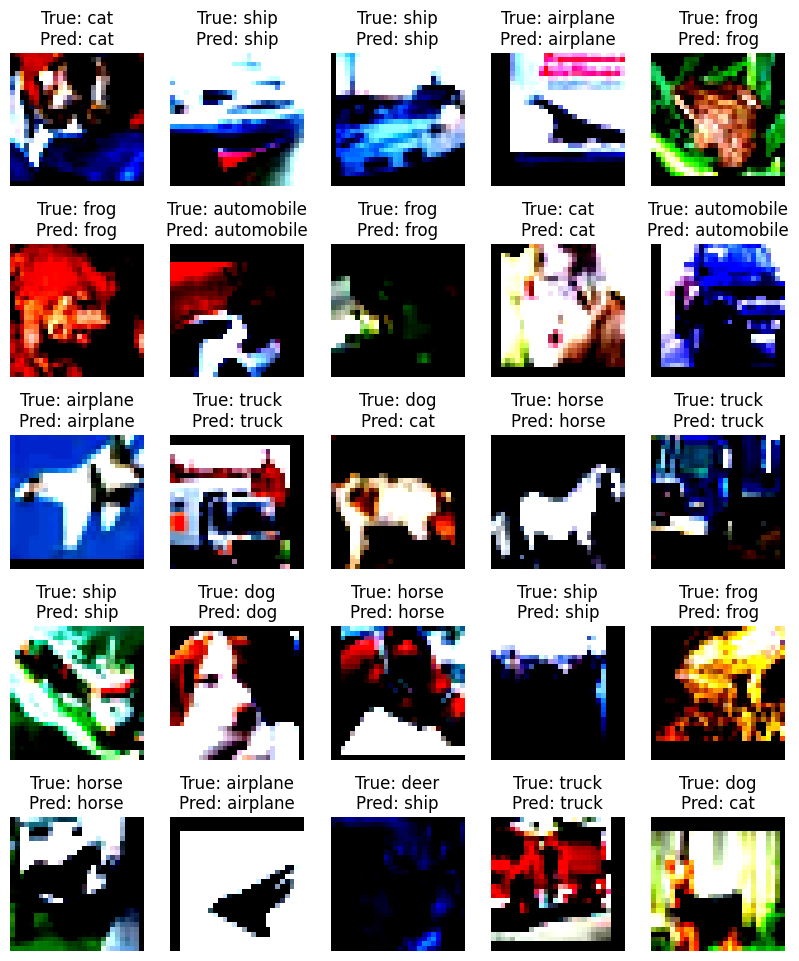

In [38]:
new_model.eval()

images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    predictions = new_model(images).argmax(1)

plt.figure(figsize=(10, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    plt.title(f"True: {labels_map[labels[i].item()]}\nPred: {labels_map[predictions[i].item()]}")
    plt.axis('off')
plt.show()

